In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.optimizers import MultiOptimizer
from sklearn.model_selection import train_test_split
import prepareVOC12 as voc

c:\Users\22428\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def fcn8s(input_shape, num_classes):
    input_img = Input(shape=input_shape)

    # Load the VGG19 model without the top layers
    base_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_img)
    for layer in base_model.layers:
        layer.trainable = False

    # Get the outputs of specific layers to be used in FCN8s
    block4_pool = base_model.get_layer('block4_pool').output
    block5_pool = base_model.get_layer('block5_pool').output

    # FCN8s layers
    conv6 = Conv2D(4096, (7, 7), activation='relu', padding='same', name='conv6')(block5_pool)
    conv7 = Conv2D(4096, (1, 1), activation='relu', padding='same', name='conv7')(conv6)
    score_fr = Conv2D(num_classes, (1, 1), activation='linear', name='score_fr')(conv7)

    # Deconvolution (transpose convolution)
    upscore2 = Conv2DTranspose(num_classes, (4, 4), strides=(2, 2), padding='same', name='upscore2')(score_fr)
    score_pool4 = Conv2D(num_classes, (1, 1), activation='linear', name='score_pool4')(block4_pool)
    fuse_pool4 = Add(name='fuse_pool4')([upscore2, score_pool4])

    upscore_pool4 = Conv2DTranspose(num_classes, (4, 4), strides=(2, 2), padding='same', name='upscore_pool4')(fuse_pool4)
    score_pool3 = Conv2D(num_classes, (1, 1), activation='linear', name='score_pool3')(base_model.get_layer('block3_pool').output)
    fuse_pool3 = Add(name='fuse_pool3')([upscore_pool4, score_pool3])

    upscore8 = Conv2DTranspose(num_classes, (16, 16), strides=(8, 8), padding='same', name='upscore8')(fuse_pool3)

    # Output
    output = tf.keras.activations.sigmoid(upscore8)

    model = Model(inputs=input_img, outputs=output)
    return model

In [3]:
class_dict = voc.class_dict
data_dir = "./VOC12/test"
labels_dir = "./VOC12/test_label"

x, y = voc.load_data(data_dir, labels_dir)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)    

(480, 224, 224, 3)
(120, 224, 224, 3)


In [4]:
# convert labels to one_hot_maps

y_train_onehot = []
y_val_onehot = []

for label_map in y_train:
    one_hot_map = voc.label_to_onehot(label_map, class_dict)
    y_train_onehot.append(one_hot_map)

for label_map in y_val:
    one_hot_map = voc.label_to_onehot(label_map, class_dict)
    y_val_onehot.append(one_hot_map)

y_train_onehot = np.array(y_train_onehot)
y_val_onehot = np.array(y_val_onehot)

In [5]:
input_shape = (224, 224, 3)
num_classes = 21
model = fcn8s(input_shape, num_classes)

In [6]:
optimizer = Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()
metric = MeanIoU(num_classes=num_classes)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [7]:
epochs = 5
batch_size = 2

history = model.fit(x_train, y_train_onehot, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val_onehot))

Epoch 1/5
240/240 [==============================] - 89s 334ms/step - loss: 0.1987 - mean_io_u: 0.4775 - val_loss: 0.1009 - val_mean_io_u: 0.4774
Epoch 2/5
240/240 [==============================] - 79s 329ms/step - loss: 0.0958 - mean_io_u: 0.4775 - val_loss: 0.0888 - val_mean_io_u: 0.4774
Epoch 3/5
240/240 [==============================] - 79s 330ms/step - loss: 0.0862 - mean_io_u: 0.4775 - val_loss: 0.0829 - val_mean_io_u: 0.4774
Epoch 4/5
240/240 [==============================] - 79s 330ms/step - loss: 0.0795 - mean_io_u: 0.4775 - val_loss: 0.0809 - val_mean_io_u: 0.4774
Epoch 5/5
240/240 [==============================] - 79s 329ms/step - loss: 0.0749 - mean_io_u: 0.4775 - val_loss: 0.0779 - val_mean_io_u: 0.4774


In [8]:
history = model.predict(x_val[:50], batch_size = 2)
y_pred = []
for onehot in history:
    y_pred.append(voc.onehot_to_label(onehot, voc.class_dict))

y_pred = np.array(y_pred).astype('uint8')
print(y_pred.shape)
print(y_pred[0].argmax())

25/25 [==============================] - 3s 132ms/step
(50, 224, 224, 3)
7293


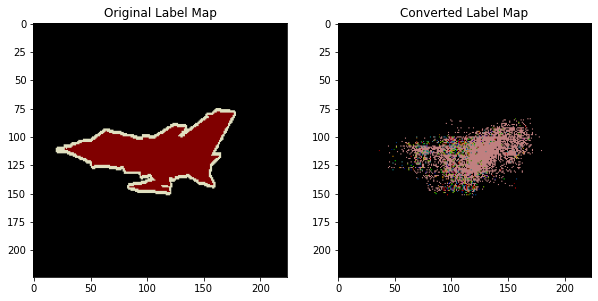

In [36]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(y_val[27])
axs[0].set_title('Original Label Map')
axs[1].imshow(y_pred[27])
axs[1].set_title('Converted Label Map')
plt.show()